\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}

\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center} 

# 1. {-}

## (a) {-}

Below is the definition of the function ```data``` that, given the value of $\rho$, will draw a sample of size 100 from the bivariate normal distribution with desired mean and covariance matrix. 

In [1]:
from scipy.stats import multivariate_normal
from pandas import DataFrame, Series
import matplotlib.pyplot as plt

sample_size = 100
mu = [1, 2]
sigma = lambda rho: [[1, rho], [rho, 1]]
dist = lambda rho: multivariate_normal(mean=mu, cov=sigma(rho))
data = lambda rho: DataFrame(dist(rho).rvs(sample_size), columns=['x', 'y'])
mean = DataFrame([mu], columns=['x', 'y'])

Use the ```data``` function to draw a sample with $\rho=0.6$. The size of the resulting sample is confirmed to be $100\times 2$.

In [2]:
X = data(rho=0.6)
X.shape

(100, 2)

Here is a comparison of the scatter plots with $\rho=0.6$ and $\rho=0.9$. 

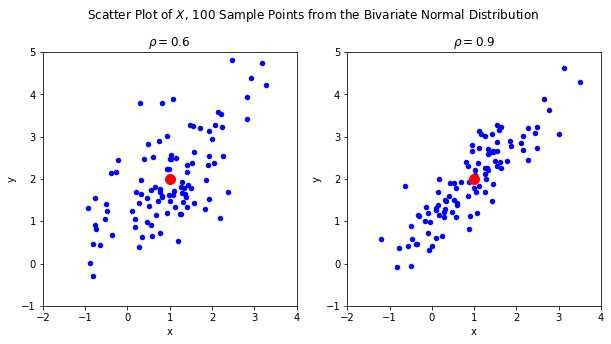

In [70]:
fig, (ax0, ax1) = plt.subplots(1, 2)

X = data(rho=0.6)
X.plot(kind='scatter', x='x', y='y', color='blue', ax=ax0) 
data(rho=0.9).plot(kind='scatter', x='x', y='y', color='blue', ax=ax1)
mean.plot(kind='scatter', x='x', y='y', color='red', s=100, xlim=(-2, 4), ylim=(-1, 5), ax=ax0)
mean.plot(kind='scatter', x='x', y='y', color='red', s=100, xlim=(-2, 4), ylim=(-1, 5), ax=ax1)

ax0.set(aspect=1, title='$\\rho = 0.6$')
ax1.set(aspect=1, title='$\\rho = 0.9$');
fig.set_size_inches(10, 5)
fig.suptitle('Scatter Plot of $X$, 100 Sample Points from the Bivariate Normal Distribution')
plt.show()

## (b) {-}

Below is the histogram of the marginal distribution. The blue line is the KDE plot and the red line is the normal pdf, the height scaled to match the sample size. 

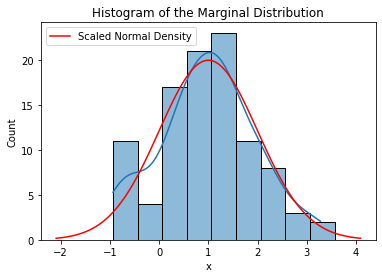

In [71]:
from scipy import stats
import numpy as np
import seaborn as sns

rho = 0.6
norm = stats.norm(loc=mu[0], scale=sigma(rho)[0][0])

binwidth = 0.5
xs = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 100)
ax = sns.histplot(data=X, x='x', kde=True, binwidth=binwidth)
ax.set(title='Histogram of the Marginal Distribution')
Series({x: binwidth*sample_size*norm.pdf(x) for x in xs}, name='Scaled Normal Density').plot(color='red', ax=ax, legend=True)
plt.show()


## (c) {-}

Below is a histogram of $Xv$. The variance looks larger than the first column of the data. In fact analytically it can be shown that $V(Xv) = 1+\rho$. 

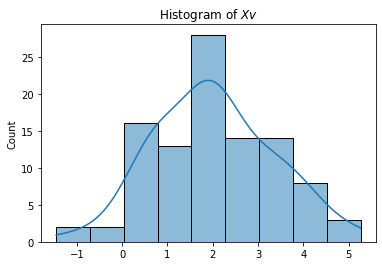

In [5]:
ax = sns.histplot(X @ [1/np.sqrt(2), 1/np.sqrt(2)], kde=True)
ax.set(title='Histogram of $Xv$')
plt.show()

## (d) {-}

The eigenvalues and eigenvectors are computed by the ```numpy.linalg.eig``` function. 

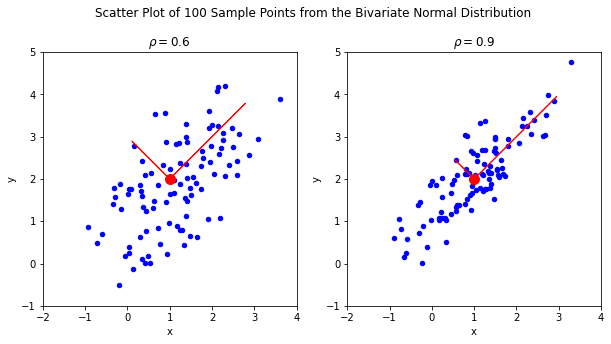

In [72]:
fig, (ax0, ax1) = plt.subplots(1, 2)

data(rho=0.6).plot(kind='scatter', x='x', y='y', color='blue', ax=ax0) 
data(rho=0.9).plot(kind='scatter', x='x', y='y', color='blue', ax=ax1)
mean.plot(kind='scatter', x='x', y='y', color='red', s=100, xlim=(-2, 4), ylim=(-1, 5), ax=ax0)
mean.plot(kind='scatter', x='x', y='y', color='red', s=100, xlim=(-2, 4), ylim=(-1, 5), ax=ax1)

w, v = np.linalg.eig(sigma(0.6))
ax0.arrow(*mu, *(2*np.sqrt(w[0])*v[:, 0]), color='r')
ax0.arrow(*mu, *(2*np.sqrt(w[1])*v[:, 1]), color='r')

w, v = np.linalg.eig(sigma(0.9))
ax1.arrow(*mu, *(2*np.sqrt(w[0])*v[:, 0]), color='r')
ax1.arrow(*mu, *(2*np.sqrt(w[1])*v[:, 1]), color='r')

ax0.set(aspect=1, title='$\\rho = 0.6$')
ax1.set(aspect=1, title='$\\rho = 0.9$');
fig.set_size_inches(10, 5)
fig.suptitle('Scatter Plot of 100 Sample Points from the Bivariate Normal Distribution')
plt.show()

## (g) {-}

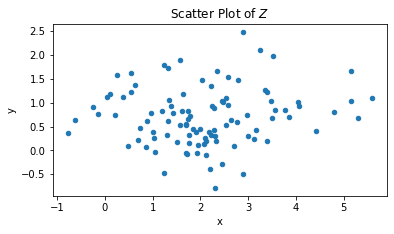

In [73]:
w, v = np.linalg.eig(sigma(0.6))
v1 = v[:, 0]
v2 = v[:, 1]

Z = DataFrame({'x': X@v1, 'y': X@v2})
ax = Z.plot(kind='scatter', x='x', y='y')
ax.set(aspect=1, title='Scatter Plot of $Z$')
plt.show()

In [8]:
print(X['x'].corr(X['y']))
print(Z['x'].corr(Z['y']))

0.6636371660390133
-0.1692895028128921


# 2. {-}

## (a) {-}

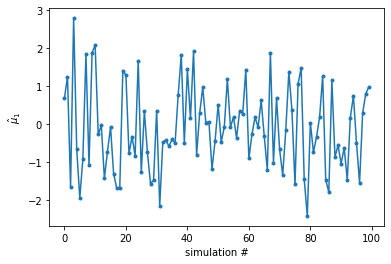

In [76]:
from pandas import Series

y1sample = [stats.norm.rvs(size=100)[0] for i in range(100)]
ss = Series(y1sample)
ax = ss.plot(style='.-')
ax.set(xlabel='simulation #', ylabel='$\hat\mu_1$')
plt.show()

In [77]:
z = stats.norm.ppf(1 - 0.025)    # 1.96

ss[(ss-z < 0) & (ss+z > 0)].size / ss.size

0.96